# Visualizing weights with captum.optim

This notebook demonstrates the use of the captum.optim submodule for visualizing the weights of the InceptionV1 model imported from Caffe.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

For convenience, we can create helper functions for visualizing the weights of our model.


In [63]:
import numpy as np
import matplotlib.pyplot as plt


def show(x: np.ndarray, scale: float = 255.0) -> None:
    x = x * scale
    plt.imshow(x.astype(np.uint8))
    plt.axis("off")
    plt.show()

def weight_heatmap(array: np.ndarray) -> np.ndarray:
    def C(x: str) -> np.ndarray:
        def H(x: str) -> float:
            return int(x, 16) / 255.0

        return np.asarray([H(x[0:2]), H(x[2:4]), H(x[4:6])])

    def weight_color_scale(x: np.float32) -> np.float32:
        if x < 0:
            x = -x
            if x < 0.5:
                x = x * 2
                return (1 - x) * C("f7f7f7") + x * C("92c5de")
            else:
                x = (x - 0.5) * 2
                return (1 - x) * C("92c5de") + x * C("0571b0")
        else:
            if x < 0.5:
                x = x * 2
                return (1 - x) * C("f7f7f7") + x * C("f4a582")
            else:
                x = (x - 0.5) * 2
                return (1 - x) * C("f4a582") + x * C("ca0020")

    return np.asarray([[weight_color_scale(x) for x in a] for a in array])

## Extracting Hidden Weights

We can extract hidden weights with Captum.optim's get_expanded_weights function.

Below we extract the hidden weights between layers mixed3a and mixed3b:

In [64]:
W_3a_3b = optimviz.circuits.get_expanded_weights(test_model, test_model.mixed3a, test_model.mixed3b)

# Visualizing hidden-hidden weights

We can visualize our newly collected hidden weights like so:

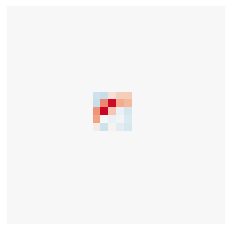

In [65]:
W_3a_3b_np = W_3a_3b.permute(1, 2, 0, 3).numpy()
show(weight_heatmap(W_3a_3b_np[:,:,147,379] / W_3a_3b_np[:,:,:,379].max()))

# NMF Visualizations of hidden-hidden weights

NMF and other dimensionality reduction alorgrithms can reveal the spaital structure of weights.

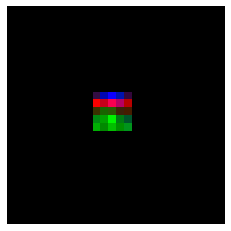

In [66]:
reducer = optimviz.ChannelReducer(3)

W_3a_3b_posneg = np.concatenate([np.maximum(0, W_3a_3b_np), np.maximum(0, -W_3a_3b_np)], axis=2)

W_nmf = reducer.fit_transform(torch.as_tensor(W_3a_3b_posneg[..., 320]), reshape=False).numpy()
W_nmf /= W_nmf.max()
show(W_nmf)